Este colab fue desarrollado por Arnold Charry Armero.

# Árboles de Decisión (Clasificación)

Los Árboles de Decisión para clasificación hacen parte de la familia de algoritmos CART (Classification and Regression Trees). Su objetivo es predecir la clase de una observación a partir de una serie de reglas de decisión que se construyen con los datos de entrenamiento. El proceso comienza evaluando posibles umbrales de partición para cada característica de la base de datos. A cada umbral se le calcula una medida de impureza (Índice de Gini o Entropía). El umbral que produzca la mayor reducción de impureza (es decir, la mejor partición) se selecciona como la regla de decisión en el nodo. Luego, el mismo procedimiento se aplica de manera recursiva en los nodos resultantes, generando nuevas particiones hasta que se cumple algún criterio de parada. Dichos criterios pueden ser un número mínimo de muestras por partición, una reducción mínima de impureza, un número máximo de niveles en el árbol, que los nodos sean puros, entre otras cosas. Se establece el Índice de Impureza de Gini matemáticamente de la siguiente manera:


$$  \text{min}\: \sum_{k=1}^{K} \hat{p_{mk}} ( 1 - \hat{p_{mk}}) $$

Se tienen unas buenas particiones, sin embargo, un árbol muy profundo puede sobreajustar. Para evitarlo, se utiliza la poda de complejidad de costo mínimo, que introduce un parámetro
$\alpha $ para penalizar árboles demasiado grandes. El árbol principal $T_{0}$ contiene cada tipo de árbol $T$ para un $\alpha$ específico que minimiza la función de error. Dentro de la función de error $T$ representa el número de hojas que tiene el árbol que se está evaluando. El error penalizado se define como:


$$ \sum_{m=1}^{|T|} \left( \frac{N_{m}}{N} \sum_{k=1}^{K} \hat{p}_{mk}\bigl(1-\hat{p}_{mk}\bigr) \right) \;+\; \alpha\,|T|$$


El $\alpha $ que minimice el error dentro de los árboles evaluados es el que se selecciona y se escoge el árbol asociado a este parámetro. Se utiliza Validación Cruzada para escoger el $\alpha $.

Ahora se continúa con la implementación en código,


In [ ]:
# Se importan las librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Machine Learning/Bases de Datos/Raisin_Dataset.csv', sep = ',')

In [ ]:
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,Kecimen
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,Kecimen
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,Kecimen
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,Kecimen
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,Kecimen


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             900 non-null    int64  
 1   MajorAxisLength  900 non-null    float64
 2   MinorAxisLength  900 non-null    float64
 3   Eccentricity     900 non-null    float64
 4   ConvexArea       900 non-null    int64  
 5   Extent           900 non-null    float64
 6   Perimeter        900 non-null    float64
 7   Class            900 non-null    object 
dtypes: float64(5), int64(2), object(1)
memory usage: 56.4+ KB


In [ ]:
df.describe()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,87804.127778,430.929950,254.488133,0.781542,91186.090000,0.699508,1165.906636
std,39002.111390,116.035121,49.988902,0.090318,40769.290132,0.053468,273.764315
min,25387.000000,225.629541,143.710872,0.348730,26139.000000,0.379856,619.074000
25%,59348.000000,345.442898,219.111126,0.741766,61513.250000,0.670869,966.410750
50%,78902.000000,407.803951,247.848409,0.798846,81651.000000,0.707367,1119.509000
75%,105028.250000,494.187014,279.888575,0.842571,108375.750000,0.734991,1308.389750
max,235047.000000,997.291941,492.275279,0.962124,278217.000000,0.835455,2697.753000


In [ ]:
df['Class'].value_counts()

,count
Class,
Kecimen,450
Besni,450


## Preprocesamiento de Datos

Se verifica a ver el tema de los faltantes,

In [ ]:
df.isnull().sum()[df.isnull().sum() != 0]

,0


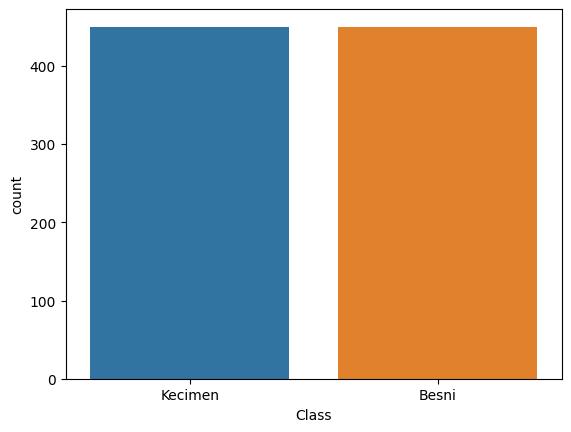

In [ ]:
# Gráfico de barras por cada clase
sns.countplot(data=df,x='Class', hue='Class')
plt.show()

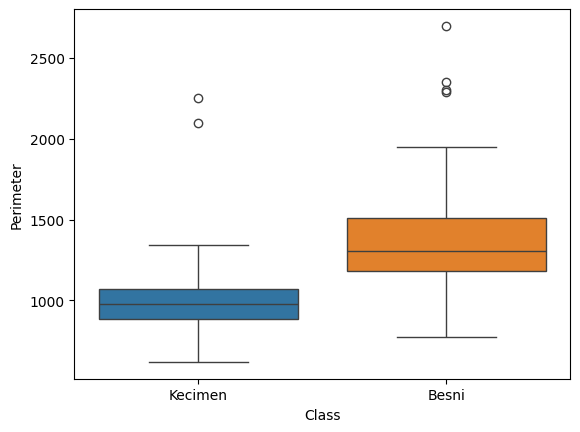

In [ ]:
# Gráfico de caja
sns.boxplot(x='Class',y='Perimeter',data=df, hue='Class')
plt.show()

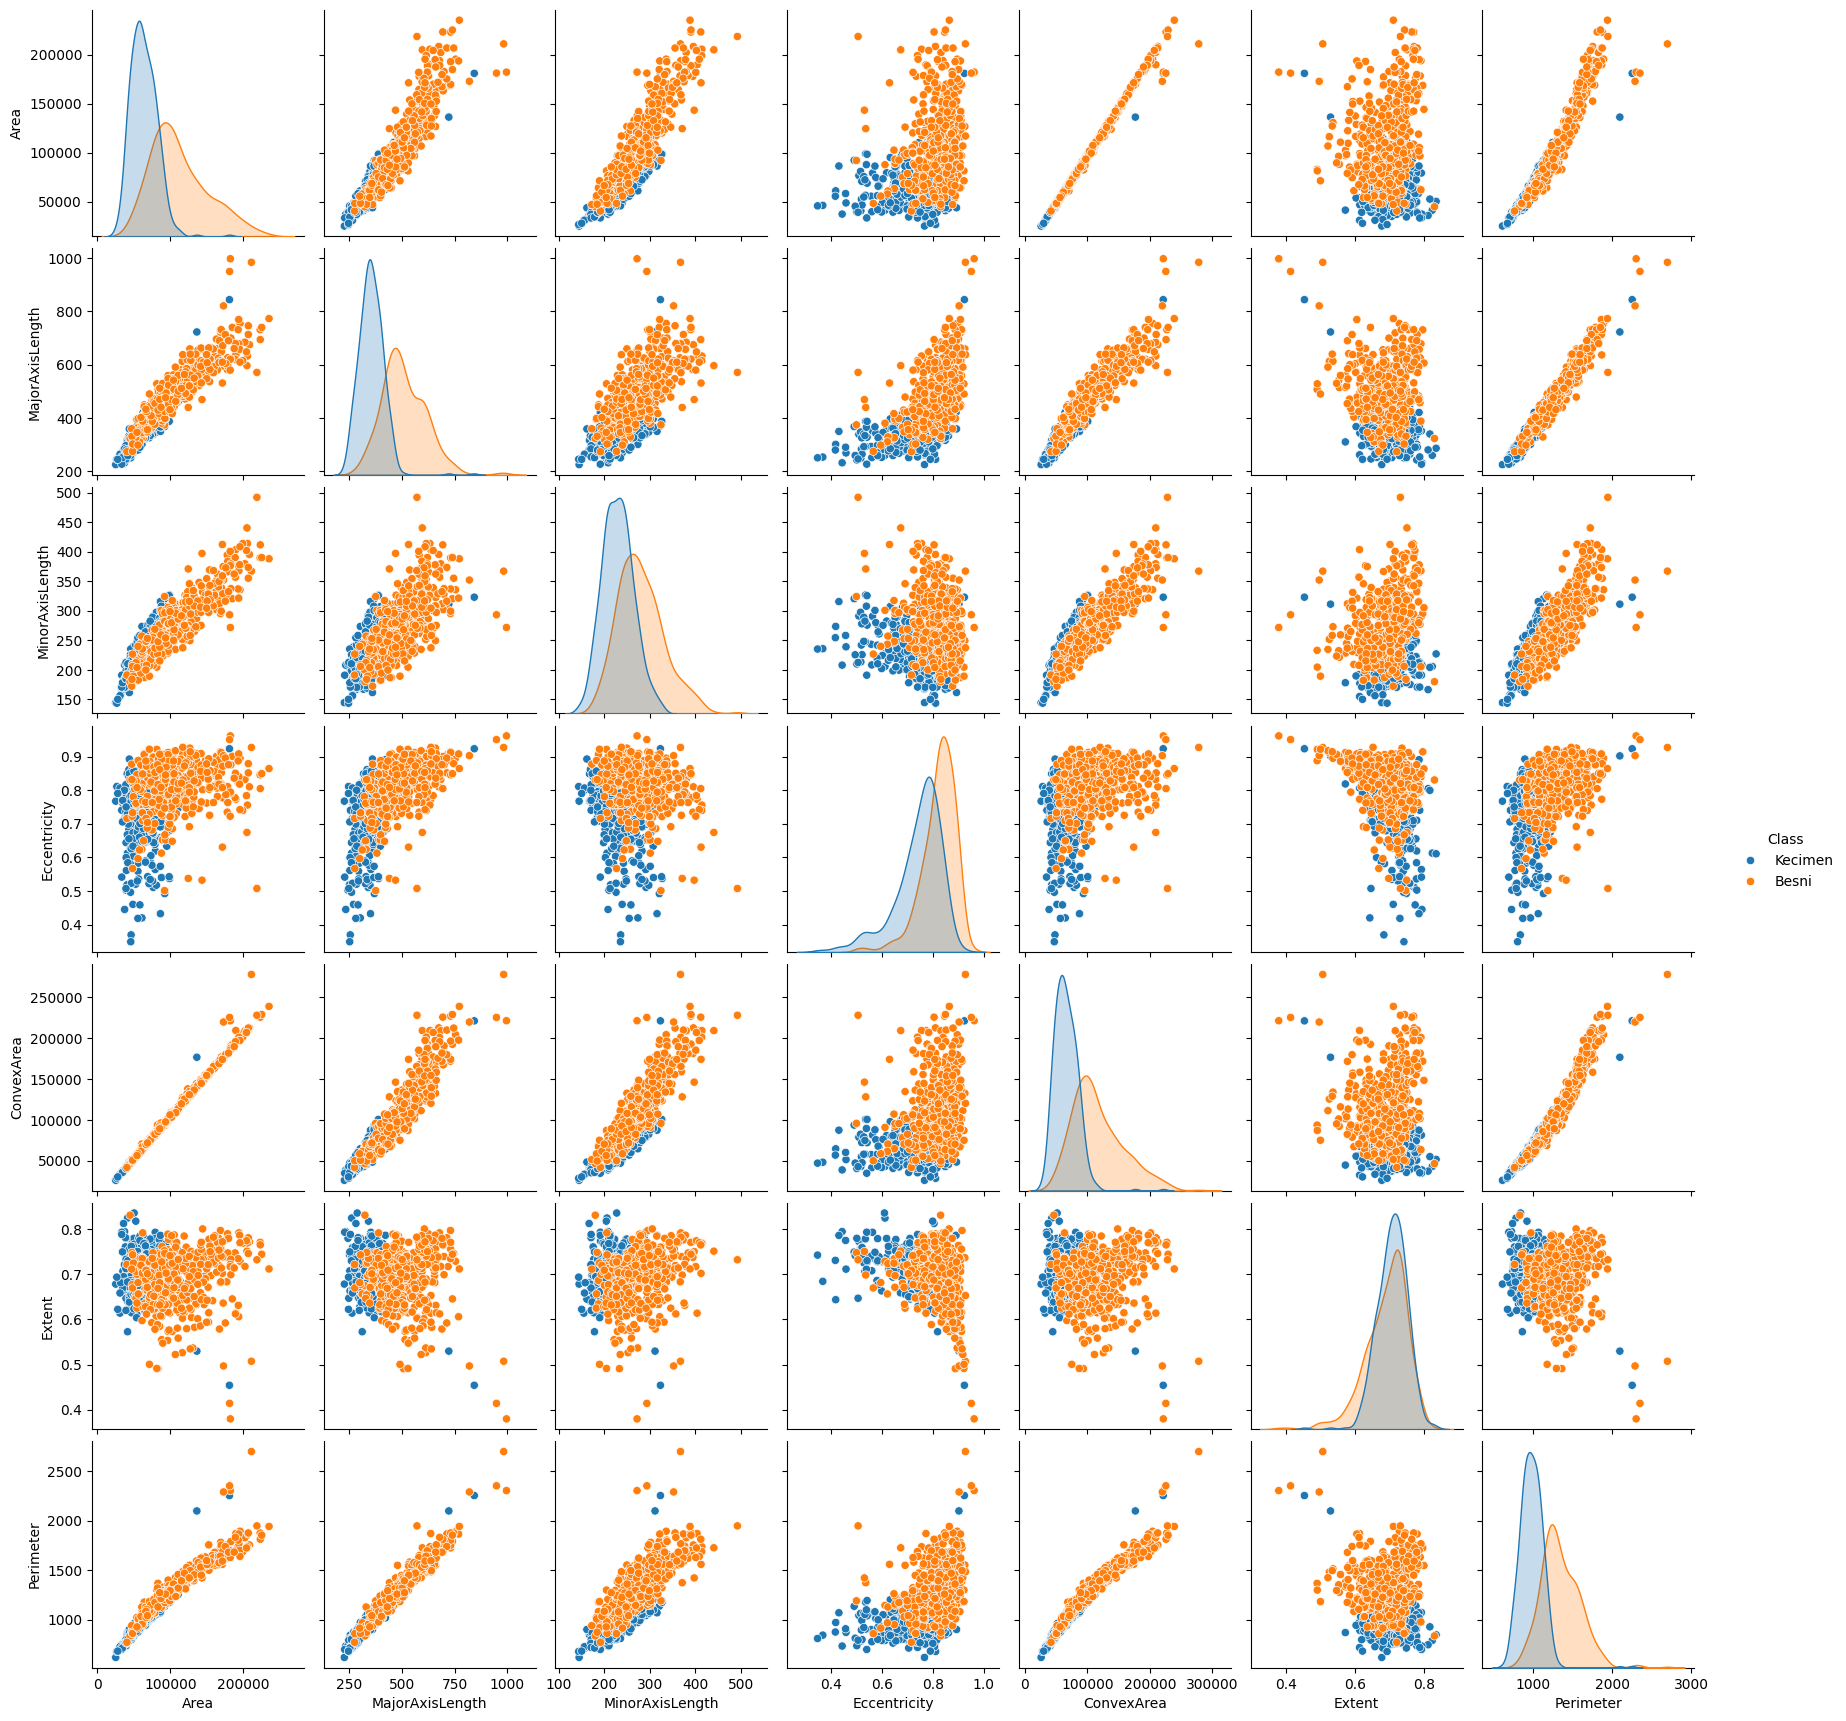

In [ ]:
sns.pairplot(df,hue='Class')
plt.show()

In [ ]:
# Obtenemos las características
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [ ]:
# Se detectan las columnas categóricas
cat_cols = df.select_dtypes(include=['object', 'category']).columns.drop(df.columns[-1])
cat_indices = [df.columns.get_loc(col) for col in cat_cols]

# Se detectan las columnas numéricas
num_indices = [i for i in range(df.shape[1] - 1) if i not in cat_indices]

# Se crea el transformador
ct = ColumnTransformer(
    transformers=[('encoder', OneHotEncoder(drop='first',sparse_output=False, dtype=int), cat_indices)],
                    remainder='passthrough')

## Separación en Base de datos de Entrenamiento y Prueba

In [ ]:
# Se divide la base de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

## Escalado de Datos

In [ ]:
# Se escalan las variables y se hace one-hot encoder
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [ ]:
# Visualizar el array X_train
print(X_train)

[[1.29292000e+05 6.14547426e+02 2.70085490e+02 ... 1.33475000e+05
  6.89689754e-01 1.53174400e+03]
 [7.99750000e+04 4.39312508e+02 2.40494190e+02 ... 8.33840000e+04
  6.91161601e-01 1.16260800e+03]
 [5.63270000e+04 2.97765725e+02 2.41934426e+02 ... 5.81780000e+04
  7.27739018e-01 9.15496000e+02]
 ...
 [1.66654000e+05 6.07996465e+02 3.49658989e+02 ... 1.69060000e+05
  7.53517688e-01 1.57416400e+03]
 [2.82160000e+04 2.45401295e+02 1.50245582e+02 ... 3.03160000e+04
  6.22292797e-01 6.83004000e+02]
 [5.78080000e+04 3.09971657e+02 2.41366511e+02 ... 5.89540000e+04
  7.10346522e-01 9.11857000e+02]]


## Entrenamiento del Modelo

Se varía en alphas para podar el árbol,

In [ ]:
# Ruta de poda
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
path = tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Se evalua cada alpha
val_scores = []
for alpha in ccp_alphas:
    model = DecisionTreeClassifier(random_state=0, ccp_alpha=alpha)
    scores = cross_val_score(model, X_train, y_train, cv=5,
                             scoring='accuracy')  # métrica de clasificación
    val_scores.append(scores.mean())

val_scores = np.array(val_scores)

# Se escoge el mejor alpha
best_alpha = float(ccp_alphas[np.argmax(val_scores)])
print("Mejor alpha según validación cruzada:", best_alpha)

# Se define rango alrededor del mejor
alpha_min = best_alpha/10 if best_alpha > 0 else ccp_alphas[1]
alpha_max = best_alpha*10 if best_alpha > 0 else ccp_alphas[-1]

# Se hace un submuestreo logarítmico (20 valores)
alphas_reducidos = np.unique(np.logspace(np.log10(alpha_min),
                                         np.log10(alpha_max),
                                         num=20))

print("Cantidad de alphas reducidos:", len(alphas_reducidos))
print(alphas_reducidos)

Mejor alpha según validación cruzada: 0.005961199294532627
Cantidad de alphas reducidos: 20
[0.00059612 0.00075962 0.00096797 0.00123345 0.00157176 0.00200285
 0.00255219 0.00325219 0.00414418 0.00528083 0.00672923 0.00857489
 0.01092676 0.0139237  0.01774262 0.02260898 0.02881006 0.03671194
 0.04678111 0.05961199]


Se entrena el modelo con el alpha seleccionado,

In [ ]:
Decision_Tree_model = DecisionTreeClassifier(criterion = 'gini', random_state = 42, ccp_alpha = best_alpha)
Decision_Tree_model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.005961199294532627, random_state=42)

Realizando una predicción,

In [ ]:
# Se debe de hacer en el orden original
print("Predicción:", Decision_Tree_model.predict(ct.transform([[79408, 352.190770, 290.827533, 0.817263, 85839, 0.668793, 1129.072]]))[0])

Predicción: Besni


In [ ]:
# Obtenemos las predicciones
y_pred = Decision_Tree_model.predict(X_test)
print(y_pred.reshape(len(y_pred),1))

[['Besni']
 ['Kecimen']
 ['Kecimen']
 ['Besni']
 ['Kecimen']
 ['Besni']
 ['Kecimen']
 ['Besni']
 ['Kecimen']
 ['Kecimen']
 ['Besni']
 ['Besni']
 ['Besni']
 ['Kecimen']
 ['Besni']
 ['Besni']
 ['Kecimen']
 ['Kecimen']
 ['Kecimen']
 ['Kecimen']
 ['Kecimen']
 ['Besni']
 ['Kecimen']
 ['Kecimen']
 ['Besni']
 ['Kecimen']
 ['Kecimen']
 ['Besni']
 ['Kecimen']
 ['Besni']
 ['Kecimen']
 ['Besni']
 ['Besni']
 ['Besni']
 ['Besni']
 ['Besni']
 ['Kecimen']
 ['Besni']
 ['Kecimen']
 ['Kecimen']
 ['Kecimen']
 ['Kecimen']
 ['Kecimen']
 ['Kecimen']
 ['Besni']
 ['Besni']
 ['Kecimen']
 ['Kecimen']
 ['Besni']
 ['Kecimen']
 ['Besni']
 ['Kecimen']
 ['Besni']
 ['Kecimen']
 ['Kecimen']
 ['Kecimen']
 ['Kecimen']
 ['Besni']
 ['Kecimen']
 ['Besni']
 ['Besni']
 ['Kecimen']
 ['Kecimen']
 ['Kecimen']
 ['Kecimen']
 ['Kecimen']
 ['Besni']
 ['Besni']
 ['Kecimen']
 ['Kecimen']
 ['Besni']
 ['Besni']
 ['Kecimen']
 ['Kecimen']
 ['Besni']
 ['Besni']
 ['Kecimen']
 ['Besni']
 ['Kecimen']
 ['Besni']
 ['Besni']
 ['Kecimen']
 ['Bes

## Rendimiento del Modelo

In [ ]:
# Obteniendo la precisión del modelo
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.8444444444444444


In [ ]:
# Matriz de confusión
confusion_matrix(y_test,y_pred)

array([[107,  22],
       [ 20, 121]])

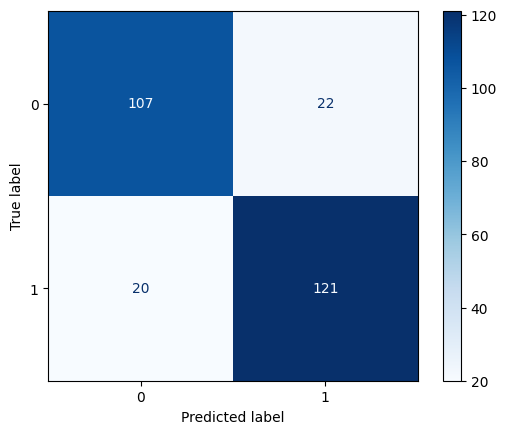

In [ ]:
# Visualizando la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [0, 1])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

In [ ]:
# Obteniendo el reporte de clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Besni       0.84      0.83      0.84       129
     Kecimen       0.85      0.86      0.85       141

    accuracy                           0.84       270
   macro avg       0.84      0.84      0.84       270
weighted avg       0.84      0.84      0.84       270



## Validación Cruzada y Grid Search

Se mide el accuracy para la diferente selección de datos de entrenamiento y prueba,

In [ ]:
# Aplicar K-fold Cross Validation
accuracies = cross_val_score(estimator = Decision_Tree_model, X = X_train, y = y_train, cv = 10, scoring = 'accuracy')
print(accuracies.mean())

0.8761904761904763


Se conocen los parámetros del Árbol de Decisión para evaluar el GridSearch.

In [ ]:
Decision_Tree_model = DecisionTreeClassifier(random_state = 42)

In [ ]:
# Parámetros
Decision_Tree_model.get_params().keys()

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'random_state', 'splitter'])

In [ ]:
# Se establecen los parámetros a probar
parameters = {'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth': [3, 5, 10, None], 'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],'max_features': [None, 'sqrt', 'log2'], 'ccp_alpha': [best_alpha]}

In [ ]:
# Se utiliza GridSearchCV
full_cv_classifier = GridSearchCV(estimator = Decision_Tree_model,
                                  param_grid = parameters,
                                  cv = 10,
                                  scoring = 'accuracy')

In [ ]:
# Se entrena el CV_Classifier
full_cv_classifier.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'ccp_alpha': [0.005961199294532627],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 5, 10, None],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [ ]:
full_cv_classifier.best_params_

{'ccp_alpha': 0.005961199294532627,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [ ]:
# Se obtiene el mejor resultado
print(full_cv_classifier.best_score_)

0.8793650793650795


Ahora se vuelve a entrenar el modelo, pero con los parámetros óptimos.

In [ ]:
model = DecisionTreeClassifier(criterion = 'gini', max_depth = 10, max_features = None, min_samples_leaf = 1,
                              min_samples_split = 2, ccp_alpha = best_alpha)
model.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.005961199294532627, max_depth=10)

In [ ]:
# Obtenemos las predicciones
y_pred = model.predict(X_test)
print(y_pred.reshape(len(y_pred),1))

[['Besni']
 ['Kecimen']
 ['Kecimen']
 ['Besni']
 ['Kecimen']
 ['Besni']
 ['Kecimen']
 ['Besni']
 ['Kecimen']
 ['Kecimen']
 ['Besni']
 ['Besni']
 ['Besni']
 ['Kecimen']
 ['Besni']
 ['Besni']
 ['Kecimen']
 ['Kecimen']
 ['Kecimen']
 ['Kecimen']
 ['Kecimen']
 ['Besni']
 ['Kecimen']
 ['Kecimen']
 ['Besni']
 ['Kecimen']
 ['Kecimen']
 ['Besni']
 ['Kecimen']
 ['Besni']
 ['Kecimen']
 ['Besni']
 ['Besni']
 ['Besni']
 ['Besni']
 ['Besni']
 ['Kecimen']
 ['Besni']
 ['Kecimen']
 ['Kecimen']
 ['Kecimen']
 ['Kecimen']
 ['Kecimen']
 ['Kecimen']
 ['Besni']
 ['Besni']
 ['Kecimen']
 ['Kecimen']
 ['Besni']
 ['Kecimen']
 ['Besni']
 ['Kecimen']
 ['Besni']
 ['Kecimen']
 ['Kecimen']
 ['Kecimen']
 ['Kecimen']
 ['Besni']
 ['Kecimen']
 ['Besni']
 ['Besni']
 ['Kecimen']
 ['Kecimen']
 ['Kecimen']
 ['Kecimen']
 ['Kecimen']
 ['Besni']
 ['Besni']
 ['Kecimen']
 ['Kecimen']
 ['Besni']
 ['Besni']
 ['Kecimen']
 ['Kecimen']
 ['Besni']
 ['Besni']
 ['Kecimen']
 ['Besni']
 ['Kecimen']
 ['Besni']
 ['Besni']
 ['Kecimen']
 ['Bes

In [ ]:
# Obteniendo la precisión del modelo
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.8444444444444444


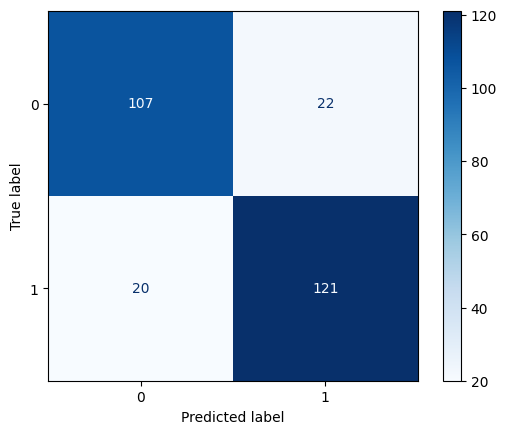

In [ ]:
# Visualizando la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [0, 1])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

In [ ]:
# Obteniendo el reporte de clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Besni       0.84      0.83      0.84       129
     Kecimen       0.85      0.86      0.85       141

    accuracy                           0.84       270
   macro avg       0.84      0.84      0.84       270
weighted avg       0.84      0.84      0.84       270



Mirando las características más importantes,

In [ ]:
# Características importantes
features = model.feature_importances_

In [ ]:
feats = pd.DataFrame(index = df.columns[:-1], data = features, columns = ["Importance"])

In [ ]:
display(feats)

,Importance
Area,0.026936
MajorAxisLength,0.812496
MinorAxisLength,0.000000
Eccentricity,0.049362
ConvexArea,0.000000
Extent,0.049710
Perimeter,0.061496


In [ ]:
imp_feats = feats[feats['Importance'] > 0]

In [ ]:
# Ordenar de mayor a menor
imp_feats = imp_feats.sort_values(by='Importance', ascending=False)

Se imprime un gráfico con las características más importantes,

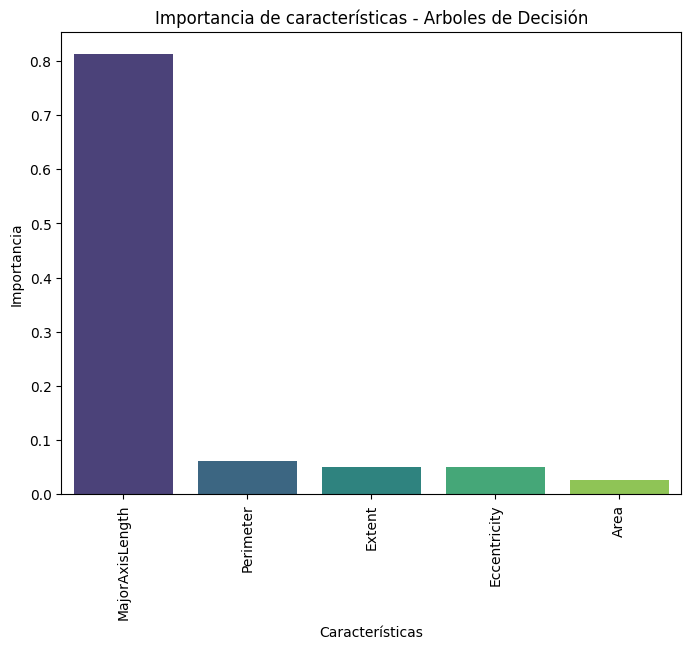

In [ ]:
# Se crea un gráfico con las características más importantes
plt.figure(figsize = (8, 6))
sns.barplot(data = imp_feats, x = imp_feats.index, y = 'Importance', hue = imp_feats.index, palette="viridis")
plt.xticks(rotation=90)
plt.xlabel("Características")
plt.ylabel("Importancia")
plt.title("Importancia de características - Arboles de Decisión")
plt.show()

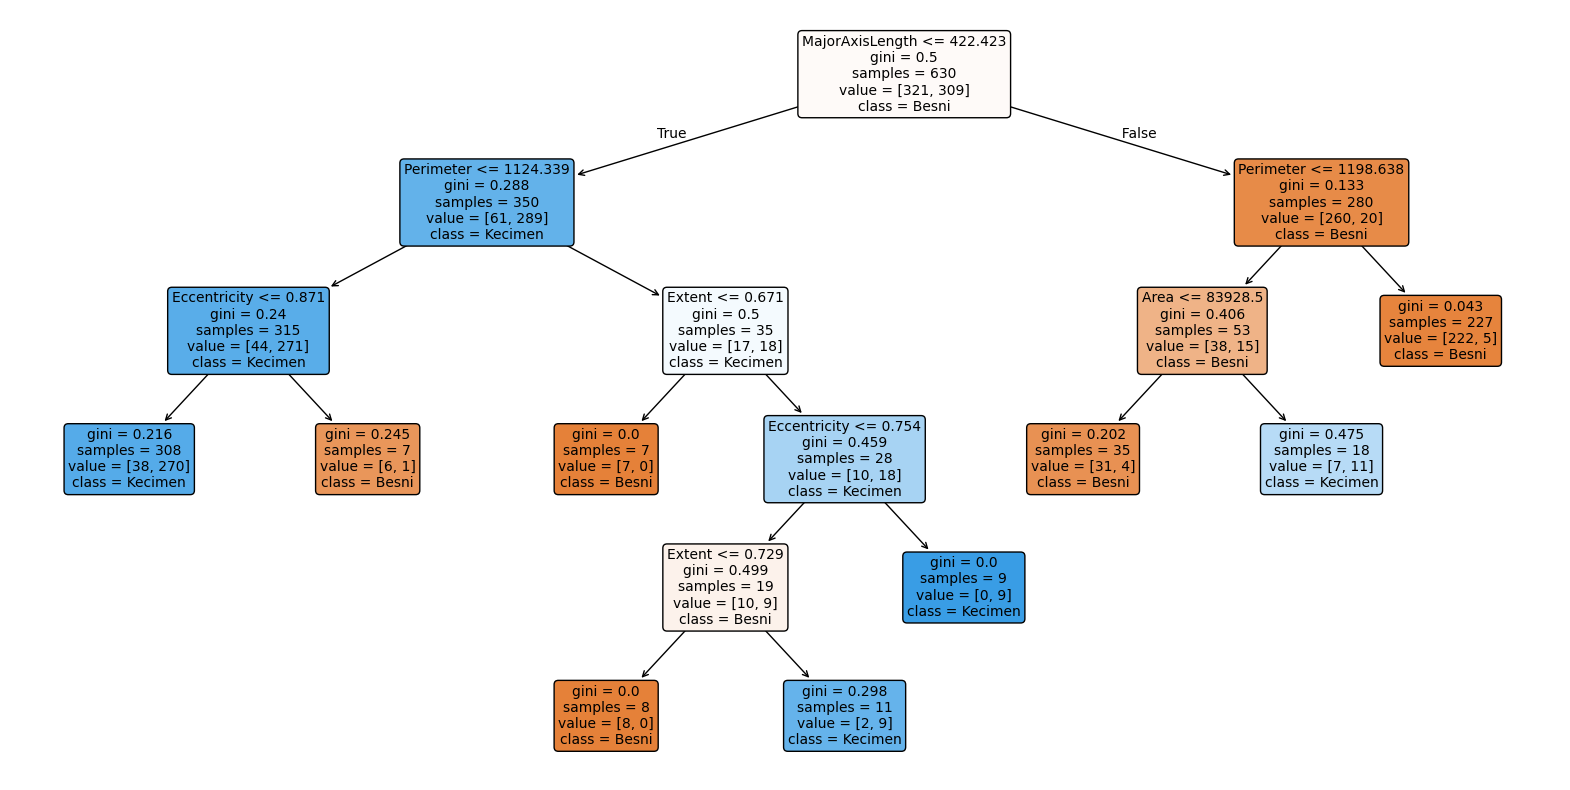

In [ ]:
# Obtener nombres de las columnas
feature_names = df.drop("Class", axis=1).columns

# Graficar el árbol de clasificación
plt.figure(figsize=(20,10))
plot_tree(model,
          filled=True,
          rounded=True,
          class_names=model.classes_.astype(str),
          feature_names=feature_names,
          fontsize=10)
plt.show()

## Referencias

*   Jacinto, V. R. (2024). Machine learning: Fundamentos, algoritmos y aplicaciones para los negocios, industria y finanzas. Ediciones Díaz de Santos.
*   James, G., Witten, D., Hastie, T., & Tibshirani, R. (2021). An Introduction to Statistical Learning: with Applications in R. https://link.springer.com/content/pdf/10.1007/978-1-0716-1418-1.pdf
*   Raisin binary classification. (2024, February 11). Kaggle. https://www.kaggle.com/datasets/nimapourmoradi/raisin-binary-classification
*   Vandeput, N. (2021). Data science for supply chain forecasting. de Gruyter.